In [1]:
!pip install git+https://github.com/paraklas/sympy2jax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paraklas/sympy2jax.git to /tmp/pip-req-build-8goe4cc6
  Running command git clone --filter=blob:none --quiet https://github.com/paraklas/sympy2jax.git /tmp/pip-req-build-8goe4cc6
  Resolved https://github.com/paraklas/sympy2jax.git to commit fb4bbbf4ab065c6db488cdb62ed262a42fb8f91c
  Preparing metadata (setup.py) ... done
  Created wheel for sympy2jax: filename=sympy2jax-0.1.0-py3-none-any.whl size=8882 sha256=06b2a145e5543daa9c3221f94c6795f9a4d60ee9d9a92e46f67e93a335132df2
  Stored in directory: /tmp/pip-ephem-wheel-cache-b627pe8k/wheels/7b/b7/f9/79b4c9819a93534bd00a1d8151259e853d4a04d2a4b299d36f
Successfully built sympy2jax


In [2]:
import jax.numpy as np
from jax import random, vmap, jit, jvp
from jax.scipy.linalg import cholesky, solve_triangular
from jax.config import config
config.update("jax_enable_x64", True)

import sympy as sp
from sympy2jax import sympy2jax
import matplotlib.pyplot as plt

In [3]:
def operator(k, x,):
    return sp.integrate(k, (x, 0.0, 1.0))

In [4]:
# Define kernels
x, xp = sp.symbols('x xp')
sigma, ell = sp.symbols('sigma ell')

k_uu = sp.simplify(sigma*sp.exp(-0.5*(sp.Pow((x-xp)/ell,2))))
k_uf = sp.simplify(operator(k_uu, xp))
k_ff = sp.simplify(operator(operator(k_uu, xp), x))

In [5]:
k_ff

-2.0*ell**2*sigma + 2.0*ell**2*sigma*exp(-0.5/ell**2) + 1.41421356237309*sqrt(pi)*ell*sigma*erf(0.707106781186548/ell)

In [6]:
k_uu_fn, k_uu_params = sympy2jax(k_uu, [x, xp, sigma, ell])
k_uf_fn, k_uf_params = sympy2jax(k_uf, [x, xp, sigma, ell])
k_ff_fn, k_ff_params = sympy2jax(k_ff, [x, xp, sigma, ell])

In [7]:
def _k_uu(params, x, xp):
    sigma = np.exp(params[0:1])
    ell = np.exp(params[1:2])
    inputs = np.concatenate([x, xp, sigma, ell]).reshape(1,4)
    return k_uu_fn(inputs, k_uu_params)[0]
    
def _k_uf(params, x, xp):
    sigma = np.exp(params[0:1])
    ell = np.exp(params[1:2])
    inputs = np.concatenate([x, xp, sigma, ell]).reshape(1,4)
    return k_uf_fn(inputs, k_uf_params)[0]
    
def _k_ff(params, x, xp):
    sigma = np.exp(params[0:1])
    ell = np.exp(params[1:2])
    inputs = np.concatenate([x, xp, sigma, ell]).reshape(1,4)
    return k_ff_fn(inputs, k_ff_params)[0]

In [8]:
def vectorize(kernel):
    vec_fun = vmap(vmap(kernel, in_axes=(None,None,0)), in_axes=(None,0,None))
    return vec_fun

In [9]:
k_uu_vec = jit(vectorize(_k_uu))
k_uf_vec = jit(vectorize(_k_uf))
k_ff_vec = jit(vectorize(_k_ff))

In [10]:
from numpy.polynomial.legendre import leggauss

N = 256
lb = np.array([0.0])
ub = np.array([1.0])
X, W = leggauss(N)
X = 0.5*(ub - lb)*(X + 1.0) + lb
X = np.array(X)[:,None]
jac_det = 0.5*(ub-lb)
params = np.log(np.array([1.0, 0.1]))

In [11]:
# Timings
%time out = k_uu_vec(params, X, X).block_until_ready()
print(out.shape)
%time out = k_uf_vec(params, X, X).block_until_ready()
print(out.shape)
%time out = k_ff_vec(params, X, X).block_until_ready()
print(out.shape)

CPU times: user 88.7 ms, sys: 4.93 ms, total: 93.6 ms
Wall time: 162 ms
(256, 256)
CPU times: user 158 ms, sys: 9.87 ms, total: 168 ms
Wall time: 216 ms
(256, 256)
CPU times: user 166 ms, sys: 3.16 ms, total: 169 ms
Wall time: 260 ms
(256, 256)


In [12]:
# Cholesky
K_uu = k_uu_vec(params, X, X) + np.eye(N)*1e-10
K_uf = k_uf_vec(params, X, X)
K_ff = k_ff_vec(params, X, X) + np.eye(N)*1e-10
K = np.vstack((np.hstack((K_uu, K_uf)),
               np.hstack((K_uf.T, K_ff))))
L = cholesky(K, lower=True)

In [13]:
# Generate samples
num_samples = 64
key = random.PRNGKey(1)
mu = 0.0
samples = mu + np.dot(L, random.normal(key, (2*N, num_samples)))
u = samples[:N,:]
Lu = samples[N:,:]

# Predicted integrals
I_gp = np.mean(Lu, axis=0)
I_gll = np.einsum('ij,i->j', u, W)*jac_det

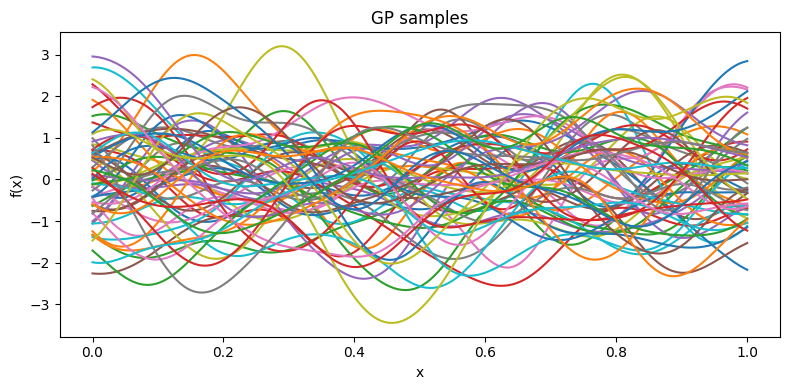

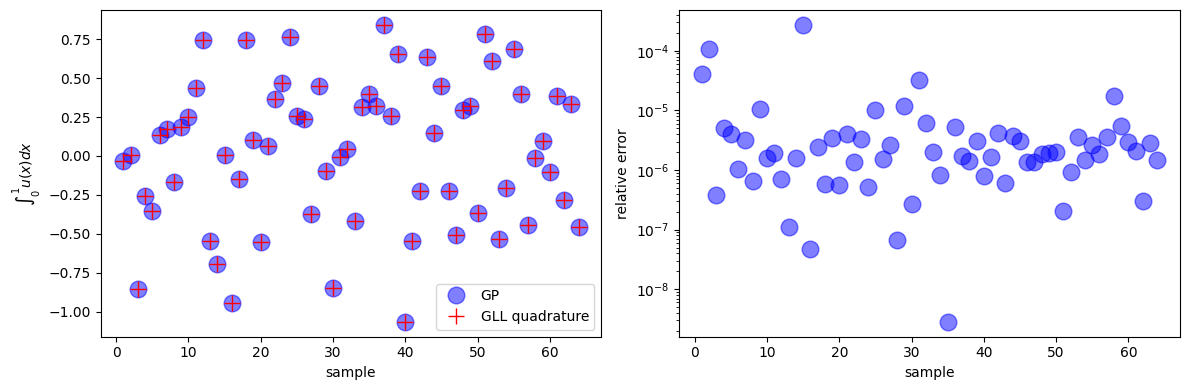

In [14]:
plt.figure(figsize=(8,4))
plt.plot(X, u)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('GP samples')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(np.arange(num_samples)+1, I_gp, 'bo', ms=12, alpha=0.5, label='GP')
plt.plot(np.arange(num_samples)+1, I_gll, 'r+', ms=12, lw=4, label='GLL quadrature')
plt.legend()
plt.xlabel('sample')
plt.ylabel('$\int_{0}^{1}u(x)dx$')
plt.subplot(1,2,2)
plt.plot(np.arange(num_samples)+1, np.abs(I_gll-I_gp)/np.abs(I_gll), 'bo', ms=12, alpha=0.5, label='GP')
plt.xlabel('sample')
plt.ylabel('relative error')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [15]:
# Generate functions whose integral is constrained to a target value
target_val = 2.0*np.pi
y = target_val*np.ones(N)

# Covariance of observations
K_ff = k_ff_vec(params, X, X) + np.eye(N)*1e-10
L = cholesky(K_ff, lower=True)
alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))

# Generate u samples
k_pp = k_uu_vec(params, X, X) + np.eye(N)*1e-10
k_pX = k_uf_vec(params, X, X)
beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
mu = np.matmul(k_pX, alpha)
mu = np.tile(mu[:,np.newaxis], (1,num_samples))
cov = k_pp - np.matmul(k_pX, beta)
Lp = cholesky(cov, lower=True)
u = mu + np.dot(Lp, random.normal(key, (N, num_samples)))

# Generate Lu samples
k_pp = k_ff_vec(params, X, X) + np.eye(N)*1e-10
k_pX = k_ff_vec(params, X, X)
alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
mu = np.matmul(k_pX, alpha)
mu = np.tile(mu[:,np.newaxis], (1,num_samples))
cov = k_pp - np.matmul(k_pX, beta)
Lp = cholesky(cov, lower=True)
Lu = mu + np.dot(Lp, random.normal(key, (N, num_samples)))

# Compute integrals via GLL quadrature
I_gll = np.einsum('ij,i->j', u, W)*jac_det
I_gp = np.mean(Lu, axis=0)

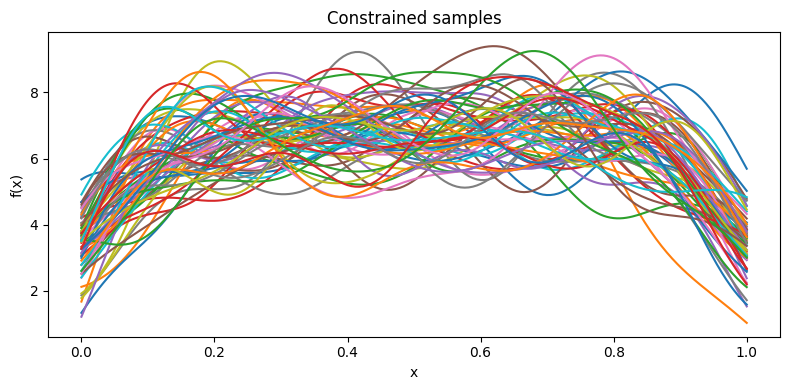

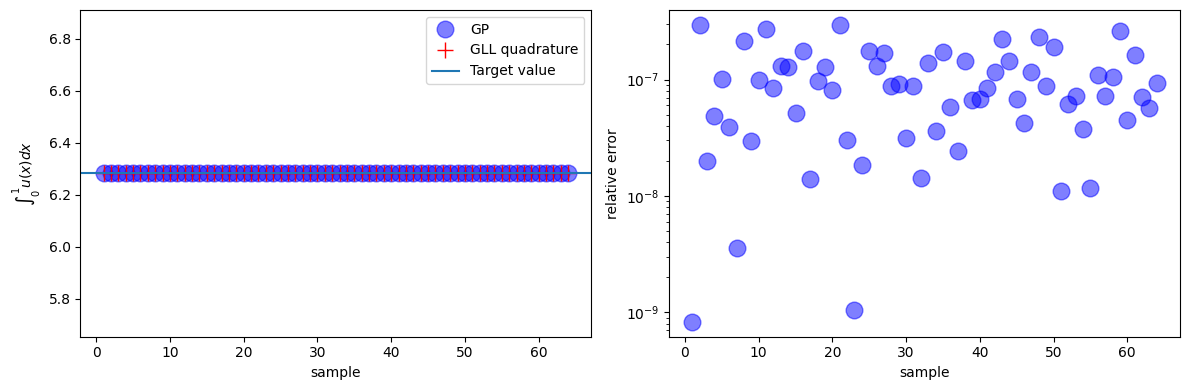

In [16]:
plt.figure(figsize=(8,4))
plt.plot(X, u)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Constrained samples')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(np.arange(num_samples)+1, I_gp, 'bo', ms=12, alpha=0.5, label='GP')
plt.plot(np.arange(num_samples)+1, I_gll, 'r+', ms=12, lw=4, label='GLL quadrature')
plt.axhline(target_val, label='Target value')
plt.legend()
plt.xlabel('sample')
plt.ylabel('$\int_{0}^{1}u(x)dx$')
plt.ylim([target_val*(1-0.1), target_val*(1+0.1)])
plt.subplot(1,2,2)
plt.plot(np.arange(num_samples)+1, np.abs(target_val-I_gp)/np.abs(target_val), 'bo', ms=12, alpha=0.5, label='GP')
plt.xlabel('sample')
plt.ylabel('relative error')
plt.yscale('log')
plt.tight_layout()
plt.show()